# Mask and Clip ICESat-2, and Difference from ASO

ICESat-2 is known to have higher accuracy over flat surfaces as opposed to rough surfaces and those with high slope. We aimed to select only ICESat-2 data points that occured in areas of slope < 20 degrees (ideally we would have chosen < 10 degrees, but a mask based on this threshold yielded almost no area within the watershed: even more ideally we would use slope of < 1 degree, as per the ATBD document https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL08_ATBD_r002_v2.pdf). We calculated slope using gdaldem with the ASO snow-off elevation data resampled to 9m resolution as the input. We clipped the ICESat-2 data to regions with this lower slope value, and then created a buffer around those points with a radius of 50m, since each ICESat-2 point represents a 100m sloping line along-track. We used zonal stats to compute the median elevation of the ASO data within each buffer, and then subtracted the ASO elevation from the ICESat-2 elevation.

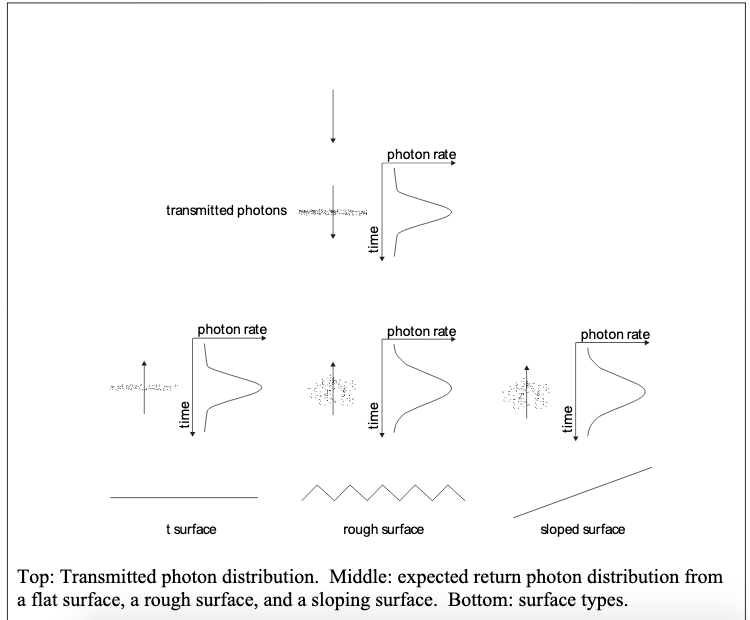

In [1]:
!pip install earthpy

  Using cached earthpy-0.9.2-py3-none-any.whl


In [2]:
#Open, Plot, and Explore Raster Data with Python 
#https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python/
#Applied to ASO Snow Off data from Tuolumne Meadows (downloaded from Linux Box Storage)

# Import necessary packages
import os
import rasterio
from rasterio.enums import Resampling
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import numpy.ma as ma
import pandas as pd
import seaborn as sns
from rasterstats import zonal_stats
import statistics
import scipy.stats as stats
# Use geopandas for vector data and rasterio for raster data
import geopandas as gpd
import rasterio as rio
import rioxarray as riox
# Plotting extent is used to plot raster & vector data together
from rasterio.plot import plotting_extent
from rasterio import features

import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

%matplotlib inline

In [12]:
#set working directory?
os.chdir(os.path.join(et.io.HOME, #set working directory?
os.chdir(os.path.join(et.io.HOME, 
                      'ICESat-2_Snowdepth'))
                      'ICESat-2_Snowdepth'))

In [13]:
#slope_fn = os.path.splitext(out_fn)[0]+'_gdaldem_slope_9m.tif'
#slope_fn

#!gdaldem slope $dtm_fn $slope_fn

In [14]:
fn = os.path.join("data",
                       "ASO_3m_dtm_USCATM__gdaldem_slope_9m.tif")
# out_fn = os.path.join('data',
#                      'ASO_3m_dtm_USCATM__gdaldem_slope_9m_output.tif')
tuol_basin_fn = os.path.join('data',
                             'UpperTuolRiverBasin',
                            'UpperTuolRiverBasinOutline.shp')

## Mask Slopes Greater than 20 Degrees

In [15]:
# Code in this cell is from David Shean, supplied in March 2021

aso_feat_list = []
ovr_scale = 8
src = rio.open(fn)
a = src.read(1, masked=True, out_shape=(src.count, int(src.height / ovr_scale), int(src.width / ovr_scale)))
ovr_transform = src.transform * src.transform.scale(src.width / a.shape[-1], src.height / a.shape[-2])
b = ma.masked_where(a > 20, a)
mask = np.ma.getmaskarray(b).astype(np.uint8) - 1
shapes = features.shapes(mask, mask=mask, transform=ovr_transform)
geom_list = list(shapes)
dt = os.path.splitext(os.path.split(fn)[-1])[0].split('_')[-1]
aso_feat_list.extend([{'properties':{'fn':fn, 'date':dt}, 'geometry':i[0]} for i in geom_list])
aso_gdf = gpd.GeoDataFrame.from_features(aso_feat_list, crs=src.crs)
#remove tiny polygons
area_thresh = 1e8
aso_gdf = aso_gdf.loc[aso_gdf.area > area_thresh]
#Shoud simplify and sieve

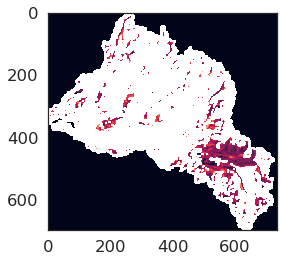

In [16]:
plt.imshow(b);

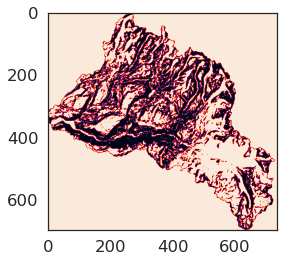

In [17]:
plt.imshow(mask);

In [18]:
aso_gdf

,geometry,fn,date
1079,"POLYGON ((254247.000 4229667.000, 254247.000 4...",data/ASO_3m_dtm_USCATM__gdaldem_slope_9m.tif,9m
1722,"POLYGON ((273336.708 4229667.000, 273336.708 4...",data/ASO_3m_dtm_USCATM__gdaldem_slope_9m.tif,9m


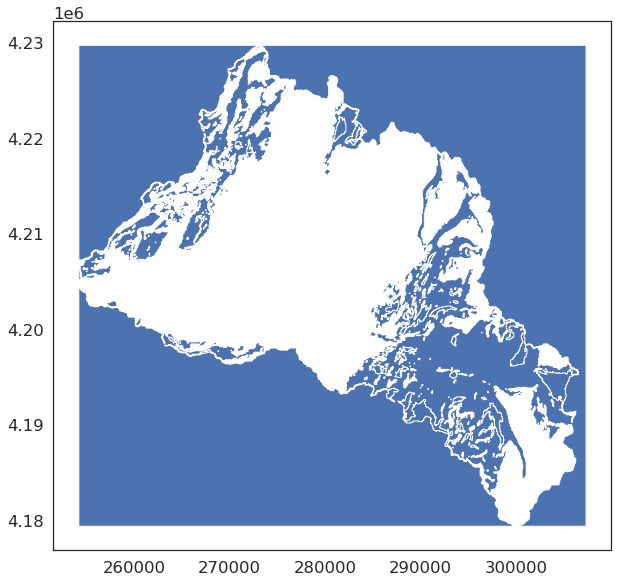

In [19]:
aso_gdf.plot(figsize=(10,10));

In [20]:
tuol_basin = gpd.read_file(tuol_basin_fn)

# Change name of .csv that you read in
atlas_df = pd.read_csv('summer_2020_pre.csv')
atlas_gdf = gpd.GeoDataFrame(atlas_df, crs='epsg:32611', geometry=gpd.points_from_xy(atlas_df.x, atlas_df.y))

In [21]:
atlas_gdf.head()

,Unnamed: 0,Track,Unnamed: 0.1,h_te_mean,h_te_median,h_te_min,h_te_max,latitude,longitude,h_te_mode,h_te_skew,n_te_photons,segment_snowcover,terrain_slope,h_te_uncertainty,dem_h,x,y,geometry,date
0,0,gt3l,0,2451.731934,2451.741455,2451.040039,2452.421387,38.218246,-119.337860,2.451700e+03,-0.117081,9.0,1.0,0.069570,272.414673,2457.634521,295338.472682,4.232614e+06,POINT (295338.473 4232614.348),2020-10-06
1,1,gt3l,1,2469.254150,2470.706543,2462.485840,2474.258545,38.216446,-119.338066,2.472800e+03,-0.682726,20.0,1.0,0.128141,123.462868,2468.296143,295315.389869,4.232415e+06,POINT (295315.390 4232414.983),2020-10-06
2,2,gt3l,2,2492.986084,2493.645996,2477.231201,2499.942383,38.215549,-119.338181,2.496700e+03,-1.348986,18.0,1.0,0.253251,138.499619,2477.662109,295302.856888,4.232316e+06,POINT (295302.857 4232315.750),2020-10-06
3,3,gt3l,3,2507.901123,2503.987061,2501.117920,2524.834717,38.214649,-119.338295,2.504000e+03,0.964010,15.0,1.0,0.287472,167.194092,2492.937012,295290.313016,4.232216e+06,POINT (295290.313 4232216.093),2020-10-06
4,4,gt3l,4,2544.308838,2538.791260,2530.073242,2563.986816,38.213932,-119.338379,3.402823e+38,0.457140,19.0,1.0,0.349252,133.912354,2512.921631,295280.954354,4.232137e+06,POINT (295280.954 4232136.689),2020-10-06


In [22]:
atlas_gdf_clipped = gpd.clip(atlas_gdf, aso_gdf, keep_geom_type=False)
atlas_gdf_clipped = gpd.clip(atlas_gdf_clipped, tuol_basin, keep_geom_type=False)

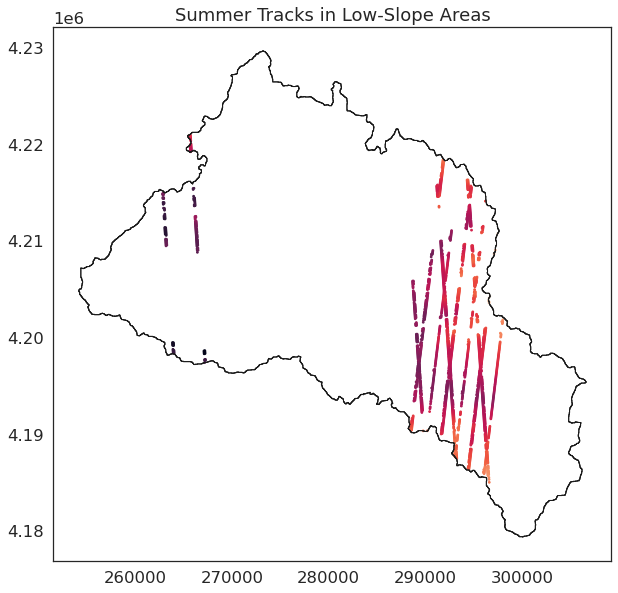

In [24]:
f, ax = plt.subplots(figsize=(10,10))
atlas_gdf_clipped.plot(ax=ax, markersize=3, c=atlas_gdf_clipped['h_te_median'])
tuol_basin.plot(ax=ax, facecolor='none', edgecolor='k')
plt.title('Summer Tracks in Low-Slope Areas');

## Difference ASO and Low-slope ICSat-2

In [25]:
atlas_buffered = atlas_gdf_clipped.copy()
atlas_buffered['geometry'] = atlas_gdf_clipped.buffer(50)
atlas_buffered = atlas_buffered.dropna(0)

In [26]:
aso_elev = os.path.join('data',
                     'mcc_dem_3p0m_agg_TUOtrimmed_MANUAL.tif')
aso_slope = os.path.join('data',
                     'ASO_3m_dtm_USCATM__gdaldem_slope_9m.tif')

In [27]:
src = rio.open(aso_slope)
#slope_unmasked = src.read(1, masked=True)

In [28]:
#slope_unmasked

In [29]:
slope_masked, slope_ma_transform = rio.mask.mask(src, aso_gdf.geometry, nodata=(0.0))

In [30]:
slope_masked.shape

(1, 5593, 5899)

In [31]:
slope_aso = zonal_stats(atlas_buffered, slope_masked.squeeze(), affine = slope_ma_transform, geojson_out=True, nodata=(-9999.), stats='median') #geojson_out=True,

In [37]:
h_aso = zonal_stats(atlas_buffered, aso_elev, geojson_out=True, nodata=(-9999.),stats='median')

In [38]:
slope_properties = [i['properties'] for i in slope_aso if 'properties' in i]
median_slope = [i['median'] for i in slope_properties if 'median' in i]

In [39]:
atlas_final = gpd.GeoDataFrame.from_features(h_aso)
atlas_final['geometry'] = gpd.points_from_xy(atlas_gdf_clipped.x, atlas_gdf_clipped.y)
atlas_final['date'] = atlas_gdf['date']
atlas_final['slope_aso'] = median_slope
atlas_final = atlas_final.rename(columns={"median": "h_aso"})
atlas_final[atlas_final == (0.)] = np.nan
atlas_final.head()

,geometry,Track,Unnamed: 0,Unnamed: 0.1,date,dem_h,h_te_max,h_te_mean,h_te_median,h_te_min,...,h_te_uncertainty,latitude,longitude,n_te_photons,segment_snowcover,terrain_slope,x,y,h_aso,slope_aso
0,POINT (292729.199 4211039.676),gt3l,211,211,2020-10-06,2738.665283,2710.320068,2705.284668,2705.417480,2698.599121,...,135.264404,38.023369,-119.361374,20.0,1.0,-0.236910,292729.198514,4.211040e+06,2717.515137,19.842838
1,POINT (292715.439 4210920.143),gt3l,212,212,2020-10-06,2710.866211,2698.244385,2689.568115,2690.274170,2680.983643,...,64.037498,38.022289,-119.361496,42.0,1.0,-0.168018,292715.438922,4.210920e+06,2689.354980,14.679496
2,POINT (292702.854 4210820.491),gt3l,213,213,2020-10-06,2691.415283,2679.886230,2672.584229,2672.218994,2667.052490,...,45.298100,38.021389,-119.361610,59.0,1.0,-0.136019,292702.854311,4.210820e+06,2672.952637,11.163389
3,POINT (292690.950 4210721.245),gt3l,214,214,2020-10-06,2675.896973,2667.184326,2663.439209,2662.855957,2661.398926,...,27.177961,38.020493,-119.361717,98.0,1.0,-0.050784,292690.950051,4.210721e+06,2663.604980,5.669123
4,POINT (292679.035 4210621.575),gt3l,215,215,2020-10-06,2665.370117,2664.345703,2661.147949,2662.689941,2653.008545,...,25.587982,38.019592,-119.361824,104.0,1.0,-0.121881,292679.034859,4.210622e+06,2661.804932,9.062229


In [40]:
atlas_final['difference'] = atlas_final['h_te_median'] - atlas_final['h_aso']

In [41]:
atlas_final['difference'].describe()

count    2544.000000
mean       -0.719889
std         2.523090
min       -23.965332
25%        -1.641968
50%        -0.564453
75%         0.315369
max        17.035156
Name: difference, dtype: float64

In [44]:
# Change name of output files depending on time frame you read in
summer_2020_difference = pd.DataFrame(atlas_final)
summer_2020_difference.to_csv('summer_2020_difference.csv')

## Plot the Results

In [5]:
# Change name of .csv that you read in
atlas_final_df = pd.read_csv('summer_2020_difference.csv')
atlas_final = gpd.GeoDataFrame(atlas_final_df, crs='epsg:32611', geometry=gpd.points_from_xy(atlas_final_df.x, atlas_final_df.y))

In [6]:
atlas_final.head()

,Unnamed: 0,geometry,Track,Unnamed: 0.1,Unnamed: 0.1.1,date,dem_h,h_te_max,h_te_mean,h_te_median,...,latitude,longitude,n_te_photons,segment_snowcover,terrain_slope,x,y,h_aso,slope_aso,difference
0,0,POINT (292729.199 4211039.676),gt3l,211,211,2020-10-06,2738.665283,2710.320068,2705.284668,2705.417480,...,38.023369,-119.361374,20.0,1.0,-0.236910,292729.198514,4.211040e+06,2717.515137,19.842838,-12.097656
1,1,POINT (292715.439 4210920.143),gt3l,212,212,2020-10-06,2710.866211,2698.244385,2689.568115,2690.274170,...,38.022289,-119.361496,42.0,1.0,-0.168018,292715.438922,4.210920e+06,2689.354980,14.679496,0.919189
2,2,POINT (292702.854 4210820.491),gt3l,213,213,2020-10-06,2691.415283,2679.886230,2672.584229,2672.218994,...,38.021389,-119.361610,59.0,1.0,-0.136019,292702.854311,4.210820e+06,2672.952637,11.163389,-0.733643
3,3,POINT (292690.950 4210721.245),gt3l,214,214,2020-10-06,2675.896973,2667.184326,2663.439209,2662.855957,...,38.020493,-119.361717,98.0,1.0,-0.050784,292690.950051,4.210721e+06,2663.604980,5.669123,-0.749023
4,4,POINT (292679.035 4210621.575),gt3l,215,215,2020-10-06,2665.370117,2664.345703,2661.147949,2662.689941,...,38.019592,-119.361824,104.0,1.0,-0.121881,292679.034859,4.210622e+06,2661.804932,9.062229,0.885010


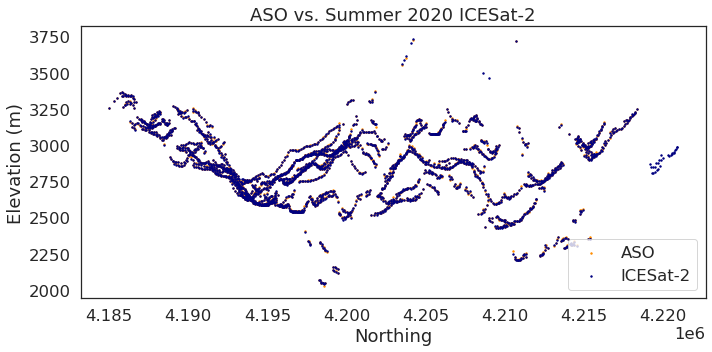

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(atlas_final['y'],atlas_final['h_aso'], c='darkorange', s=2, label = 'ASO')
ax.scatter(atlas_final['y'],atlas_final['h_te_median'], c='navy', s=2, label = 'ICESat-2')
#ax.set_ylim(1750, 3300)
ax.set_xlabel('Northing')
ax.set_ylabel('Elevation (m)')
ax.set_title('ASO vs. Summer 2020 ICESat-2')
ax.legend(loc = 'lower right')
fig.tight_layout()
plt.savefig('2020_dif_ASO_profile.jpeg', dpi=300)
#ax.set_xlim(4.196*(10**6),4.215*(10**6))

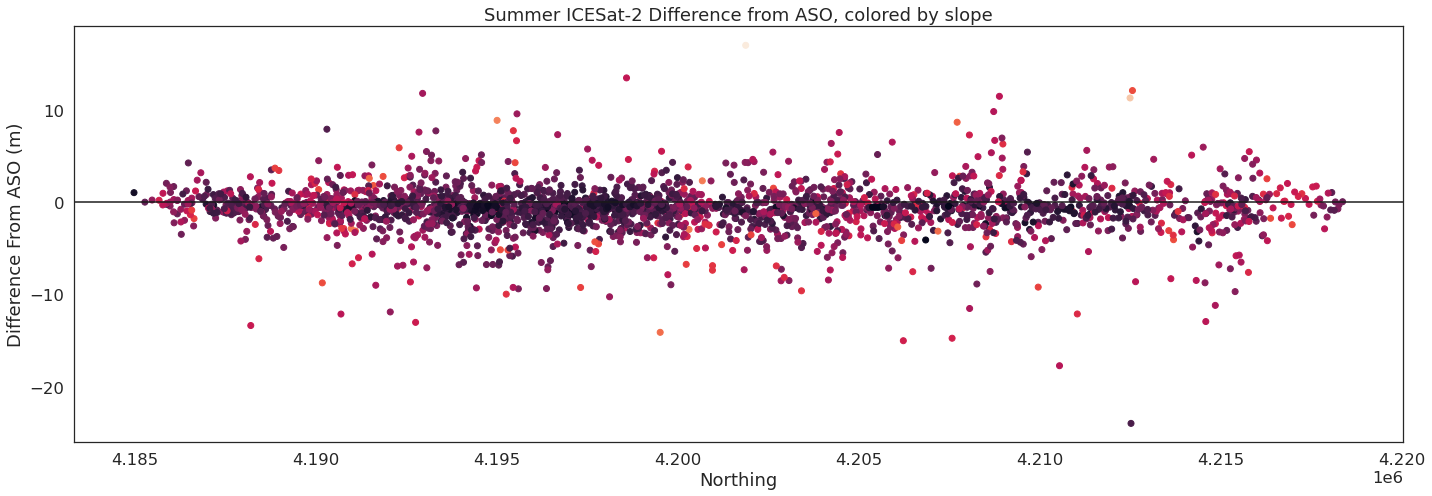

In [8]:
fig, ax = plt.subplots(figsize=(20,7))
ax.scatter(atlas_final['y'],atlas_final['difference'], c=atlas_final['slope_aso'])
ax.axhline(y=0, c='k')

#plt.xlim( 4.19e+06, 4.2176e+06)
#plt.ylim(-6, 3)
plt.xlabel('Northing')
plt.ylabel('Difference From ASO (m)')
plt.title('Summer ICESat-2 Difference from ASO, colored by slope')
plt.tight_layout()
plt.savefig('2020_Dif.jpeg', dpi=300)

In [29]:
# atlas_final[atlas_2020_final['difference'] < (-250)] = np.nan
# atlas_final[atlas_2020_final['difference'] > (250)] = np.nan